## Temporal GNNs

In [1]:
#!pip install --upgrade pandas

In [2]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q torch-geometric-temporal==0.54.0

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Forecasting web traffic

In [3]:
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.dataset import WikiMathsDatasetLoader
from torch_geometric_temporal.nn.recurrent import EvolveGCNH

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

dataset = WikiMathsDatasetLoader().get_dataset()
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.5)

In [4]:
mean_cases = [snapshot.y.mean().item() for snapshot in dataset]
std_cases = [snapshot.y.std().item() for snapshot in dataset]
df = pd.DataFrame(mean_cases, columns=['mean'])
df['std'] = pd.DataFrame(std_cases, columns=['std'])
df['rolling'] = df['mean'].rolling(7).mean()

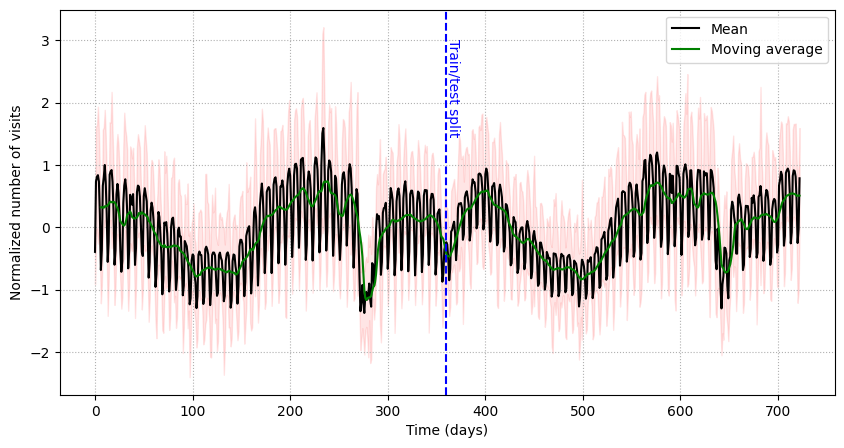

In [5]:
plt.figure(figsize=(10,5))
plt.plot(df['mean'], 'k-', label='Mean')
plt.plot(df['rolling'], 'g-', label='Moving average')
plt.grid(linestyle=':')
plt.fill_between(df.index, df['mean']-df['std'], df['mean']+df['std'], color='r', alpha=0.1)
plt.axvline(x=360, color='b', linestyle='--')
plt.text(360, 1.5, 'Train/test split', rotation=-90, color='b')
plt.xlabel('Time (days)')
plt.ylabel('Normalized number of visits')
plt.legend(loc='upper right')

## EvolveGCN-H model

In [6]:
from torch import nn

# EvolveGCN-H model
class TemporalGNN(nn.Module):
  def __init__(self, node_count, dim_in):
    super().__init__()
    self.recurrent = EvolveGCNH(node_count, dim_in)
    self.linear = nn.Linear(dim_in, 1)

  def forward(self, x, edge_index, edge_weight):
    h = self.recurrent(x, edge_index, edge_weight).relu()
    h = self.linear(h)
    return h

model = TemporalGNN(dataset[0].x.shape[0], dataset[0].x.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

TemporalGNN(
  (recurrent): EvolveGCNH(
    (pooling_layer): TopKPooling(8, ratio=0.00749063670411985, multiplier=1.0)
    (recurrent_layer): GRU(8, 8)
    (conv_layer): GCNConv_Fixed_W(8, 8)
  )
  (linear): Linear(in_features=8, out_features=1, bias=True)
)

In [7]:
# train loop
for epoch in tqdm(range(50)):
  for i, snapshot in enumerate(train_dataset):
    y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    loss = torch.mean((y_pred-snapshot.y)**2)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

# evaluation
model.eval()
loss = 0
for i, snapshot in enumerate(test_dataset):
  y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
  mse = torch.mean((y_pred-snapshot.y)**2)
  loss += mse
loss = loss/(i+1)
print(f'MSE {loss.item():.4f}')

100%|██████████| 50/50 [06:56<00:00,  8.33s/it]


MSE 0.7733


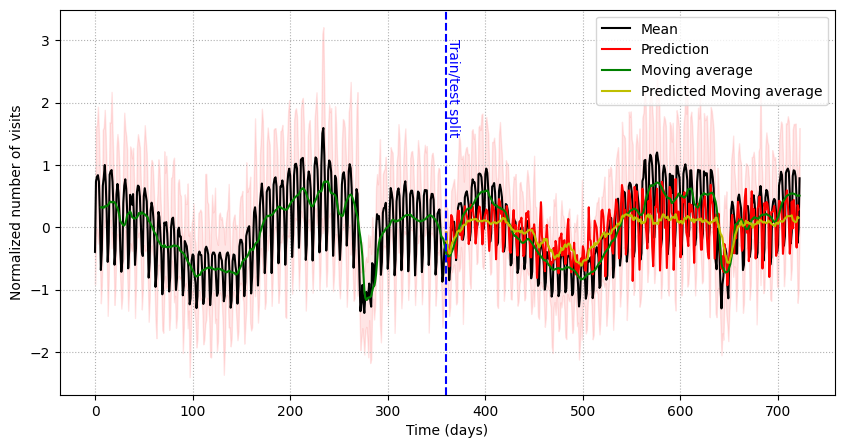

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

y_preds = [model(snapshot.x, snapshot.edge_index,
                 snapshot.edge_attr).squeeze().detach().numpy().mean()
                 for snapshot in test_dataset]

y_preds_series = pd.Series(y_preds, index=range(360, 360 + len(y_preds)))
pred_rolling = y_preds_series.rolling(7, min_periods=1).mean()

if 'item id' not in df.columns:
    df = df.reset_index()

df.loc[pred_rolling.index, 'pred_rolling'] = pred_rolling.values

plt.figure(figsize=(10, 5))
plt.plot(df['mean'], 'k-', label='Mean')
plt.plot(y_preds_series.index, y_preds_series, 'r-', label='Prediction')
plt.plot(df['rolling'], 'g-', label='Moving average')
plt.plot(pred_rolling.index, pred_rolling, 'y-', label='Predicted Moving average')
plt.grid(linestyle=':')
plt.fill_between(df.index, df['mean'] - df['std'], df['mean'] + df['std'], color='r', alpha=0.1)
plt.axvline(x=360, color='b', linestyle='--')
plt.text(360, 1.5, 'Train/test split', rotation=-90, color='b')
plt.xlabel('Time (days)')
plt.ylabel('Normalized number of visits')
plt.legend(loc='upper right')
plt.show()


<Axes: >

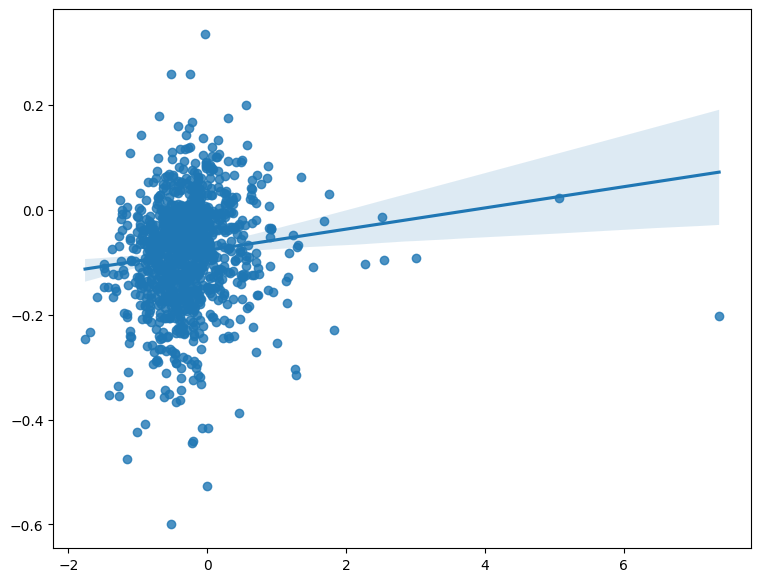

In [9]:
import seaborn as sns

y_pred = model(test_dataset[0].x, test_dataset[0].edge_index, test_dataset[0].edge_attr).detach().squeeze().numpy()

plt.figure(figsize=(9,7))
sns.regplot(x=test_dataset[0].y.numpy(), y=y_pred)

## COVID-19 cases prediction

England Covid dataset, a dynamic graph with temporal information introduced by Panagopoulos et al. in 2021.

This dataset represents the number of reported cases of COVID-19 in 129 England NUTS 3 regions between March 3 and May 12, 2020. Data was collected from mobile phones that installed the Facebook application and shared their location history. Our goal is to predict the number of cases in each node (region) in 1 day.

This dataset represents England as a graph G = (V, E)

Edges are unidirectional and weighted representing the number of people that moved from region to region over time. These graphs also contain self-loops corresponding to people moving within the same region.

## MPNN-LSTM
Panagopoulos et al., 2021

In [10]:
from torch_geometric_temporal.dataset import EnglandCovidDatasetLoader

dataset = EnglandCovidDatasetLoader().get_dataset(lags=14)

In [11]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

Text(0, 0.5, 'Mean normalized number of cases')

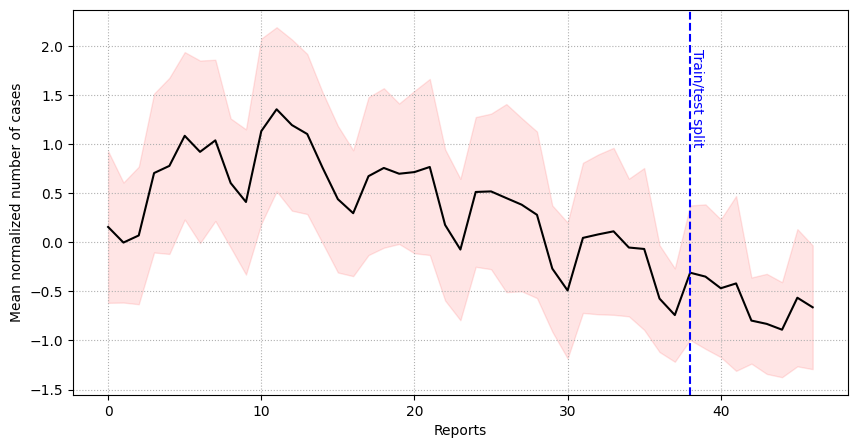

In [12]:
# plotting
mean_cases = [snapshot.y.mean().item() for snapshot in dataset]
std_cases = [snapshot.y.std().item() for snapshot in dataset]
df = pd.DataFrame(mean_cases, columns=['mean'])
df['std'] = pd.DataFrame(std_cases, columns=['std'])

plt.figure(figsize=(10,5))
plt.plot(df['mean'], 'k-')
plt.grid(linestyle=':')
plt.fill_between(df.index, df['mean']-df['std'], df['mean']+df['std'], color='r', alpha=0.1)
plt.axvline(x=38, color='b', linestyle='--', label='Train/test split')
plt.text(38, 1, 'Train/test split', rotation=-90, color='b')
plt.xlabel('Reports')
plt.ylabel('Mean normalized number of cases')

In [13]:
from torch_geometric_temporal.nn.recurrent import MPNNLSTM

class TemporalGNN(nn.Module):
  def __init__(self, dim_in, hidden, num_nodes):
    super().__init__()
    self.recurrent = MPNNLSTM(dim_in, hidden, num_nodes,
                              1, # window
                              0.5, # dropout
                              )
    self.dropout = nn.Dropout(0.5)
    self.linear = nn.Linear(2*hidden + dim_in, 1)

  def forward(self, x, edge_index, edge_weight):
    h = self.recurrent(x, edge_index, edge_weight).relu()
    h = self.dropout(h)
    h = self.linear(h).tanh()
    return h

model = TemporalGNN(dataset[0].x.shape[1], 64, dataset[0].x.shape[0])
model

TemporalGNN(
  (recurrent): MPNNLSTM(
    (_convolution_1): GCNConv(14, 64)
    (_convolution_2): GCNConv(64, 64)
    (_batch_norm_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (_batch_norm_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (_recurrent_1): LSTM(128, 64)
    (_recurrent_2): LSTM(64, 64)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=142, out_features=1, bias=True)
)

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()

for epoch in tqdm(range(100)):
  loss = 0
  for i, snapshot in enumerate(train_dataset):
    y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    loss = loss + torch.mean((y_pred-snapshot.y)**2)
  loss = loss / (i+1)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

model.eval()
loss = 0
for i, snapshot in enumerate(test_dataset):
  y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
  mse = torch.mean((y_pred-snapshot.y)**2)
  loss += mse
loss = loss / (i+1)
print(f'\nMSE: {loss.item():.4f}')

100%|██████████| 100/100 [00:36<00:00,  2.72it/s]


MSE: 1.4502


Text(0, 0.5, 'Mean normalized number of cases')

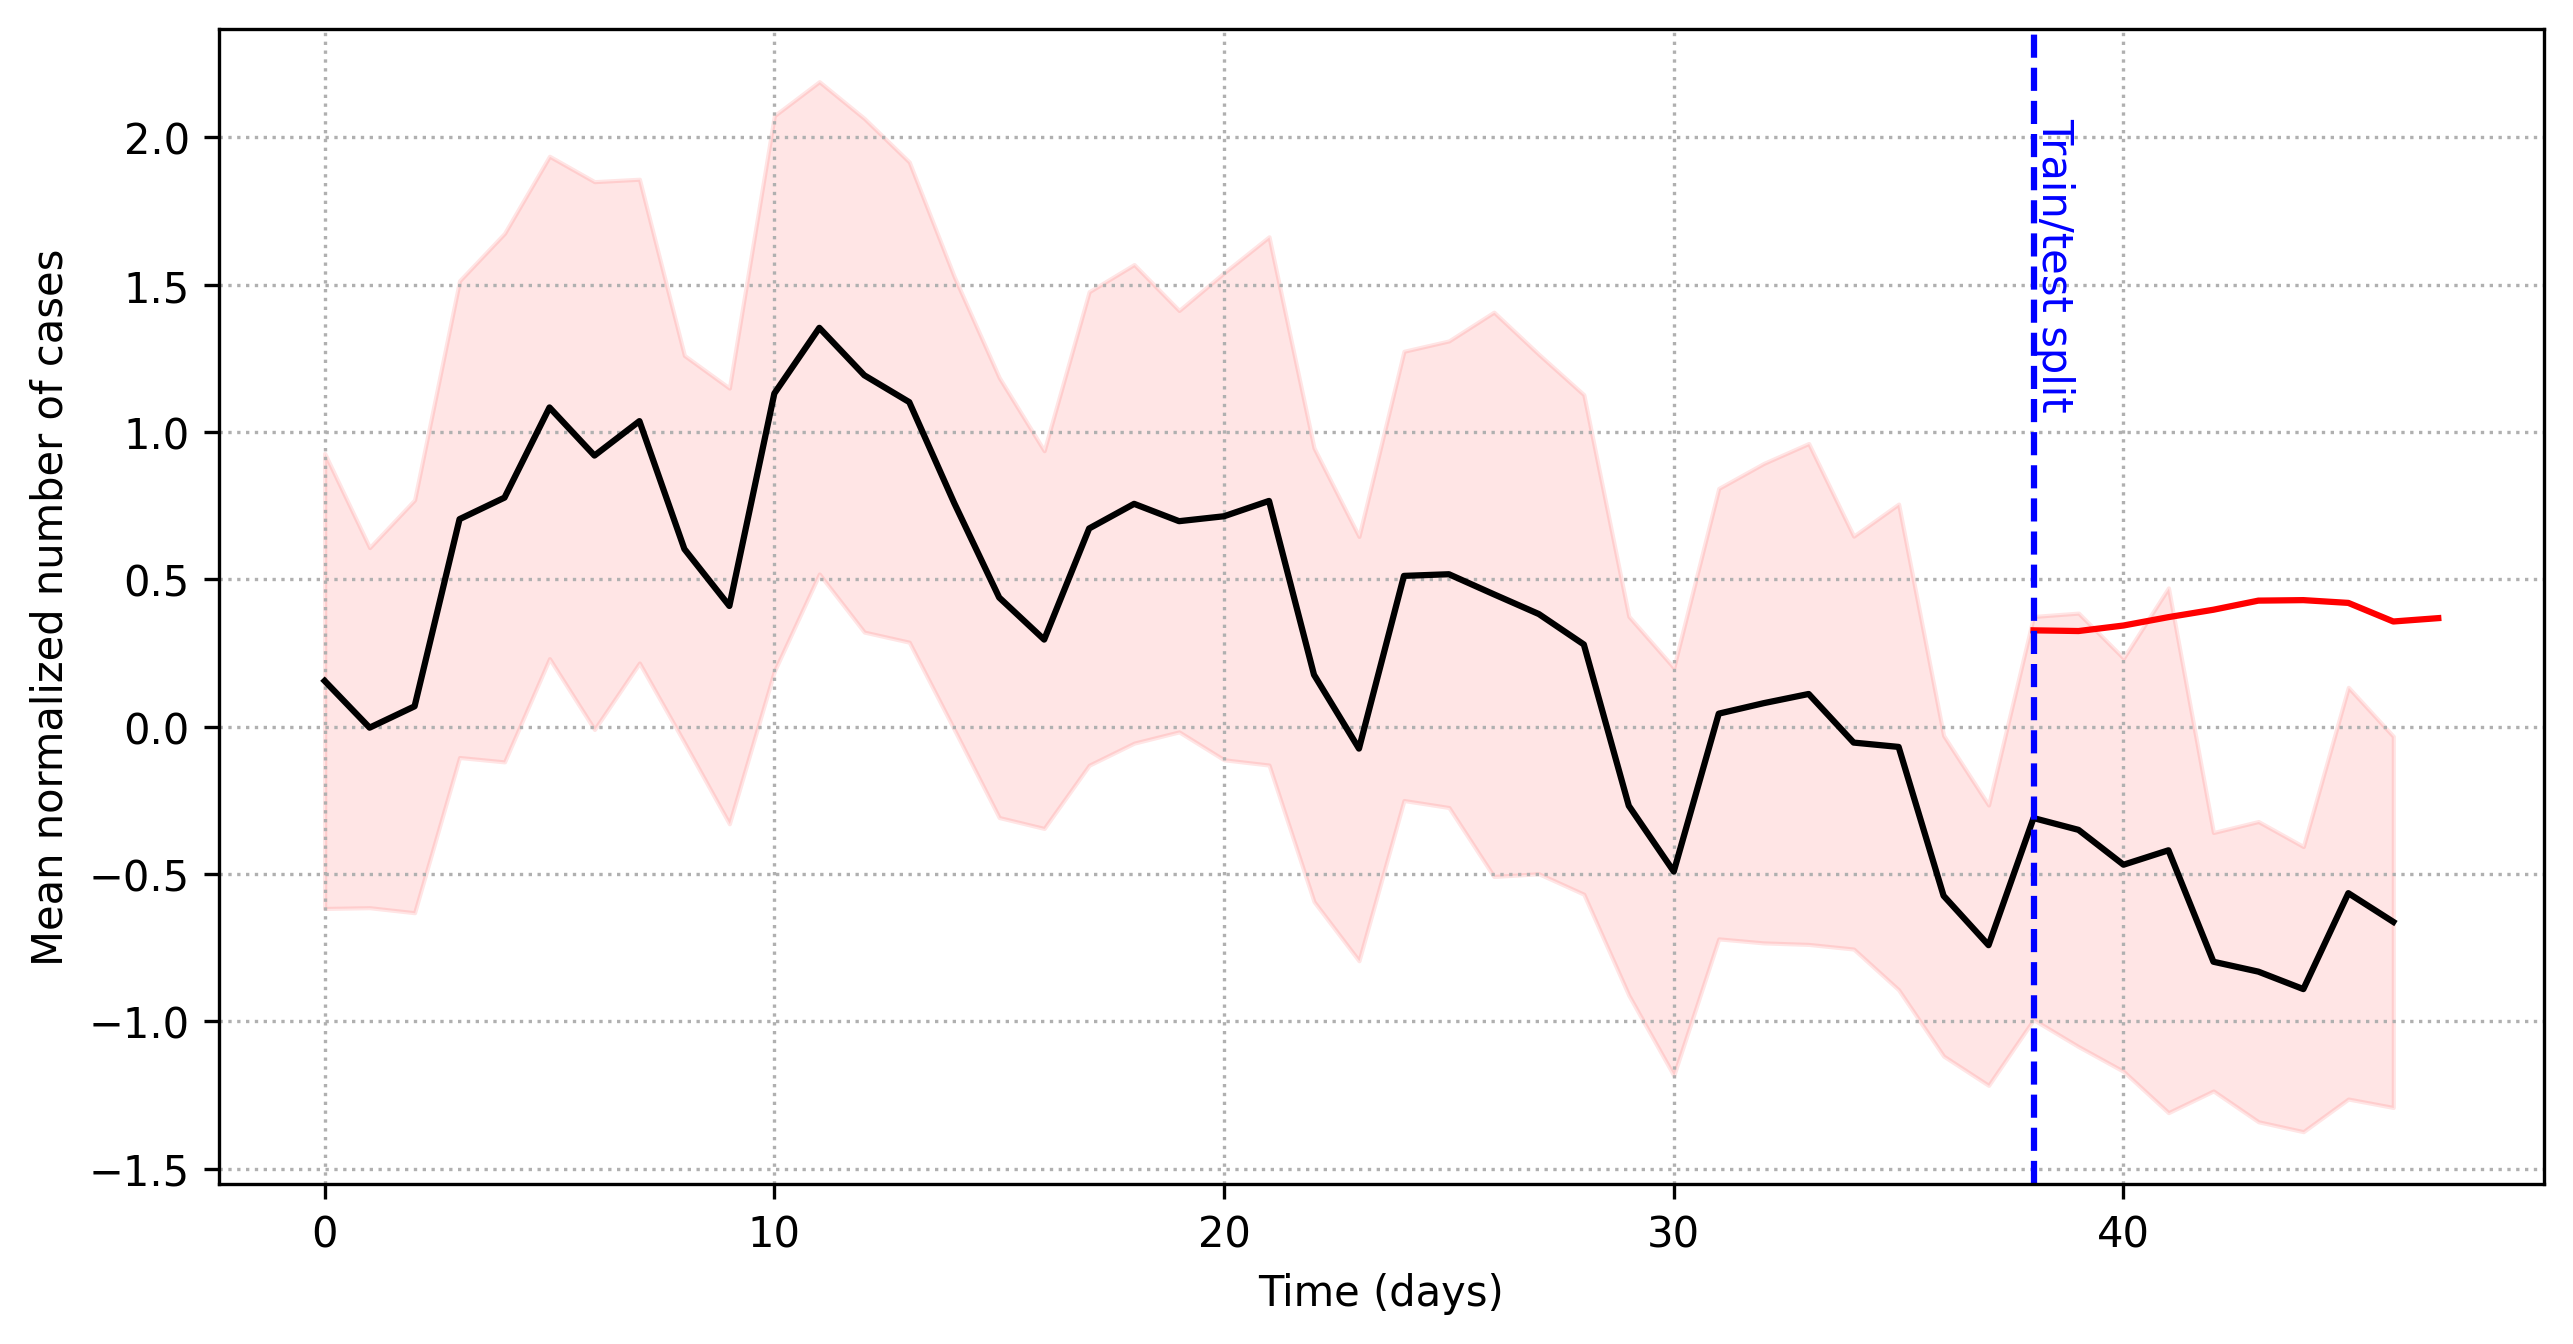

In [15]:
y_preds = [model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).squeeze().detach().numpy().mean() for snapshot in test_dataset]

plt.figure(figsize=(10,5), dpi=300)
plt.plot(df['mean'], 'k-')
plt.plot(range(38,48), y_preds, 'r-', label='Prediction')
plt.grid(linestyle=':')
plt.fill_between(df.index, df['mean']-df['std'], df['mean']+df['std'], color='r', alpha=0.1)
plt.axvline(x=38, color='b', linestyle='--', label='Train/test split')
plt.text(38, 1.1, 'Train/test split', rotation=-90, color='b')
plt.xlabel('Time (days)')
plt.ylabel('Mean normalized number of cases')

As expected, the predicted values do not match the ground truth very well. This is probably due to the lack of data in this small dataset.